# Assignment 5 - Rigid Registration

In [181]:
## Import Libraries
import numpy as np
from PIL import Image

import imageio

#
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use("fivethirtyeight")

## Part 1

Part A

Find the centers of mass of the static and moving zebrafish.

Static Image_20449.tif

Moving Image_20450.tif

Align the centers of mass.

Start rotating around the center of mass of the static and measuring SSD (theta).

After you find the angle where SSD is minimized start translating (t_x and ty).

Plot SSD for theta, tx and ty.

You can use scipy.ndimage (affine_transform or rotate/shift functions).

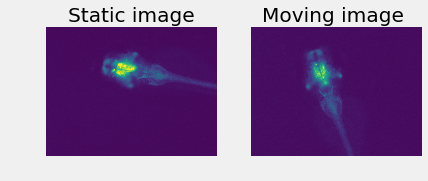

In [184]:
"""
Read image
"""
def read_image(file):
    image = imageio.imread(file)
    return image

"""
Show image
"""
def show_image(image,title=""):
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
    
"""
Plot two images
"""
def plot_two_images(static, moving, text=""):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(static)
    plt.title("Static image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(moving)
    plt.title("Moving image" + " " + text)
    plt.axis("off")
    plt.show()
    
    
# image1
image1 = read_image("Image_20449.tif")
image2 = read_image("Image_20450.tif")

plot_two_images(image1, image2)

In [3]:
static = np.copy(image1)
moving = np.copy(image2)


### Threshold Image

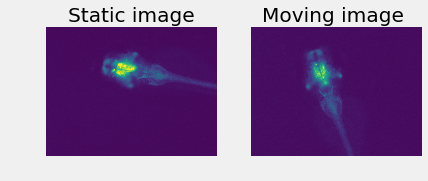

In [185]:
## Threshold image
def threshold_image(im):
    im[im<np.mean(im)]=0
    return im

static = threshold_image(static)
moving = threshold_image(moving)

plot_two_images(image1, image2)

### Compute and Shift - Center of Mass

In [5]:
import scipy.ndimage as ndimage
center_of_mass = lambda c: ndimage.center_of_mass(c)

c_static = center_of_mass(static)
c_moving = center_of_mass(moving)
print(f"center of mass of static image:{c_static}\ncenter of mass of moving image: {c_moving}")

center of mass of static image:(353.03383577521976, 719.61164787227585)
center of mass of moving image: (482.76525416165532, 604.61981823637416)


In [187]:
## shift by center of mass
def shift_by_com(static, moving):
    c_s = center_of_mass(static)
    c_m = center_of_mass(moving)
    shift = (c_s[0] - c_m[0],c_s[1] - c_m[1])
    shifted = ndimage.shift(moving, shift)
    return shifted

moving = shift_by_com(static, moving)
c_static = center_of_mass(static)
c_moving = center_of_mass(moving)
print(f"center of mass of static image:{c_static}\ncenter of mass of moving image: {c_moving}")

center of mass of static image:(353.03383577521976, 719.61164787227585)
center of mass of moving image: (354.73105556865681, 720.25930179797115)


## Images after shifting center of mass of moving to align with static

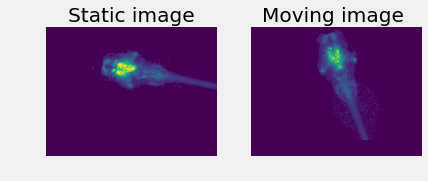

In [188]:
## show_images
plot_two_images(static, moving, text="")

### Start rotating around the center of mass of the static and measuring SSD (theta).


In [189]:
"""
SSD metric
"""
def compute_ssd(im1, im2):
    img1 = np.copy(im1)
    img2 = np.copy(im2)
    shape_0 = min(im1.shape[0],im2.shape[0])
    shape_1 = min(im1.shape[1],im2.shape[1])
    metric =  -1*np.mean((img1[:shape_0,:shape_1]-img2[:shape_0,:shape_1])**2)
    return metric

## 1. Computing Rotations

In [190]:
"""
Stack overflow:
https://stackoverflow.com/questions/25458442/rotate-a-2d-image-around-specified-origin-in-python
"""
def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    pad_width = np.array([padY, padX],dtype='i')
    imgP = np.pad(img, pad_width, 'constant')
    imgR = ndimage.rotate(imgP, angle,order=2)
    return imgR[int(padY[0]) : -int(padY[1]), int(padX[0]) : -int(padX[1])]

"""
Rotate image
"""
def rotate(image,angle):
    rotated = np.copy(image)
    rotated = ndimage.rotate(rotated, angle)
    return rotated
    
rotations = np.arange(0,200,2)
ssd_values = []
for angle in rotations:
    rotated = rotateImage(moving, angle,c_moving)
    metric = compute_ssd(static,rotated)
    ssd_values.append(metric)
    

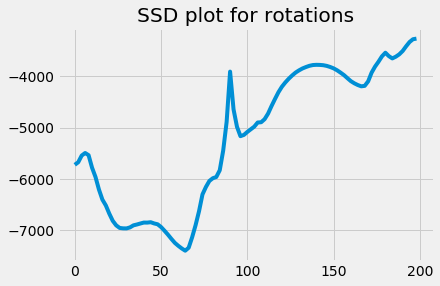

In [191]:
plt.plot(rotations, ssd_values)
plt.title("SSD plot for rotations")
plt.show()

### rotate image:


In [192]:
min_rotation_angle = np.argmin(ssd_values)
print(f"min rotation occurs at: {rotations[int(min_rotation_angle)]}")

min rotation occurs at: 64


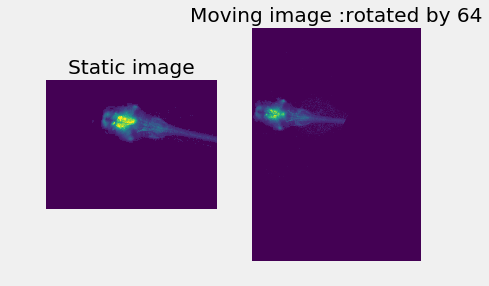

In [193]:
rotated_moving_images = np.copy(moving)
rotated = rotateImage(moving,64,c_moving)
plot_two_images(static, rotated, ":rotated by 64")

## 2. Computing translation coordinates

### Linear translations

### Translation 

In [255]:
import numpy as np
def linear_x_translation(image, shift):
    ty,tx = shift
    trans_image = ndimage.affine_transform(moving, [1, 1], [-ty, -tx], order=2)
    return trans_image

mse_values = []
X, Y = np.meshgrid(np.linspace(-20, 10, 50),np.linspace(-25,10,50))
miny,minx = (0,0)
min_mismatch = 9999
cnt = 0
translations = np.rec.fromarrays([X,Y], names='x,y')

for  (ty,tx) in np.ravel(translations):
    shifted = linear_x_translation(moving, (ty,tx))
    mismatch = compute_ssd(shifted, static)
    cnt+=1
    if mismatch<min_mismatch:
        min_mismatch = mismatch
        miny,minx = (ty,tx)
    mse_values.append(mismatch)



In [256]:
print(f"Min values {miny,minx}, number of points tested {cnt}")

Min values (-18.775510204081634, 4.2857142857142847), number of points tested 2500


### Translate

In [257]:
translated_image = ndimage.affine_transform(ndimage.rotate(moving,64,reshape=False),[1,1],(-miny,-minx))


### Final Output



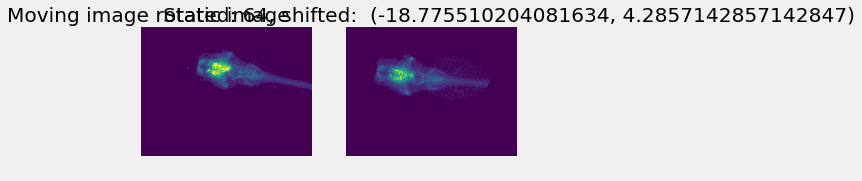

In [258]:
plot_two_images(static, translated_image, f"rotated: {64}, shifted:  {(miny, minx)}")

## Part 2

Connect an optimizer (Powell's or L-BFGS-B) to the 2D zebrafish registration method that you created in the previous assignment. Both optimizers are available in scipy. See documentation and tutorials here 

 https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.htmlLinks to an external site.

https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.htmlLinks to an external site.

Now you shouldn't need the for loops any more. The optimizer should be able to figure our the 3 parameters LaTeX: \theta,\:t_x,\:t_y θ , t x , t y . Enjoy hacking!

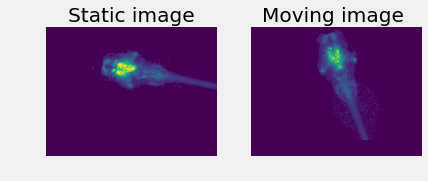

In [259]:
## moving images around center of mass
plot_two_images(static, moving)

In [260]:
#Powell's or (L-BFGS-B)
from scipy import optimize

In [261]:
## function to perform translations, affine translations
from numpy import *

"""
Rotation
"""
def rotate_image(image,a):
    ## bilinear interpolation
    src = np.copy(image)
    transformed_image= rotateImage(src, a,c_moving)
    return transformed_image


"""
Compute cost of rotation
""" 
def cost_of_transformation_rotation(x_y_rotation_trans):
    """
    Given the cost function,
    """
    unshifted = rotate_image(moving, x_y_rotation_trans)
    return compute_ssd(static, unshifted)

"""
call back method
"""
def trying_params(params):
    print("trying_params: " + str(params))
    

"""
Cost of translations
"""  
def cost_of_transformation_translation(shift):
    """
    Given the cost function,
    """
    y, x = shift
    unshifted = ndimage.affine_transform(moving, [1, 1], [-y, -x], order=2)
    return compute_ssd(static, unshifted)


trying_params: [ 64.91079346]
trying_params: [ 64.92184725]
trying_params: [ 64.92186618]
Optimization terminated successfully.
         Current function value: -7412.507256
         Iterations: 3
         Function evaluations: 66
Best params 64.92186617606018


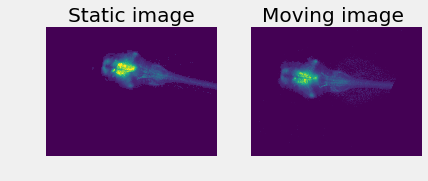

In [262]:
## Powell
best_params = optimize.fmin_powell(cost_of_transformation_rotation,[np.rad2deg(1)],callback=trying_params)

best_params

## rotate image
print("Best params",best_params)
rotated = ndimage.rotate(moving,best_params,reshape=False)
plot_two_images(static, rotated)

In [264]:
## Linear translations

## Powell
best_params = optimize.fmin_powell(cost_of_transformation_translation,(-20,0),callback=trying_params)

best_params

## rotate image
print("Best params",best_params)


trying_params: [-23.7236037   0.9860758]
trying_params: [-23.72509028  -1.63195819]
trying_params: [-23.73247631  -1.63203189]
trying_params: [-23.71282279  -1.6318547 ]
Optimization terminated successfully.
         Current function value: -5806.351669
         Iterations: 4
         Function evaluations: 161
Best params [-23.71282279  -1.6318547 ]


Best params [-23.71282279  -1.6318547 ]


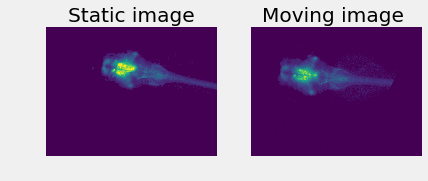

In [266]:
## rotate image
print("Best params",best_params)
shifted = ndimage.shift(rotated,best_params)
plot_two_images(static, shifted)